How does the traffic of Taxi rides change along the day?

In order to answer this question, I would use K-means clustering to cluster New York into different groups based on location, and analyze the traffic into and out of every cluster as a function of the time along the day. One can expect that residential areas would have more incoming traffic in the evening, whereas commercial areas would mostly attract people during the day, and areas with rich nightlife would show more traffic in the night. 

This can be helpful in duration prediction, as we can learn what are the likely destinations for each area during different times of the day.

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

sample_submission.csv
test.csv
train.csv



### Read the data

In [2]:
df = pd.read_csv('../input/train.csv')

### Remove rides to and from far away areas

In [3]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

### Plot rides

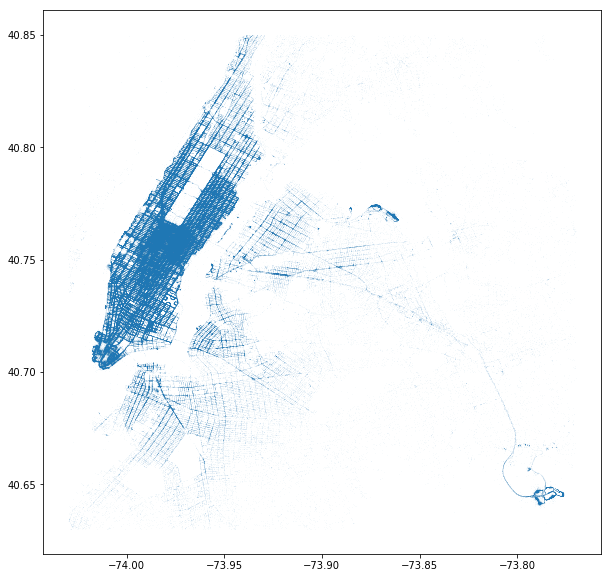

In [4]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)


plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

In [5]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

### Cluster

Let's cluster New York City based on the pick-up and drop-off points of each taxi ride

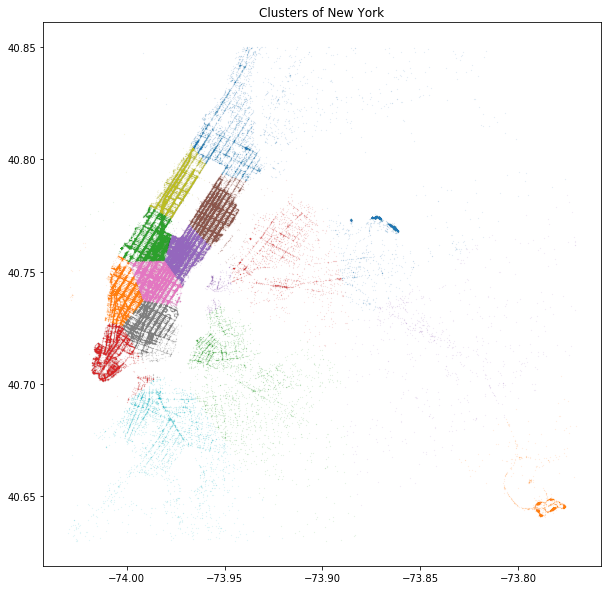

In [6]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

As we can see, the clustering results in a partition which is somewhat similar to the way NY is divided into different neighborhoods. We can see Upper East and West side of Central park in gray and pink respectively. West midtown in blue, Chelsea and West Village in brown, downtown area in blue, East Village and SoHo in purple.

The airports JFK and La LaGuardia have there own cluster, and so do Queens and Harlem. Brooklyn is divided into 2 clusters, and the Bronx has too few rides to be separated from Harlem. 
 
Let's plot the cluster centers:

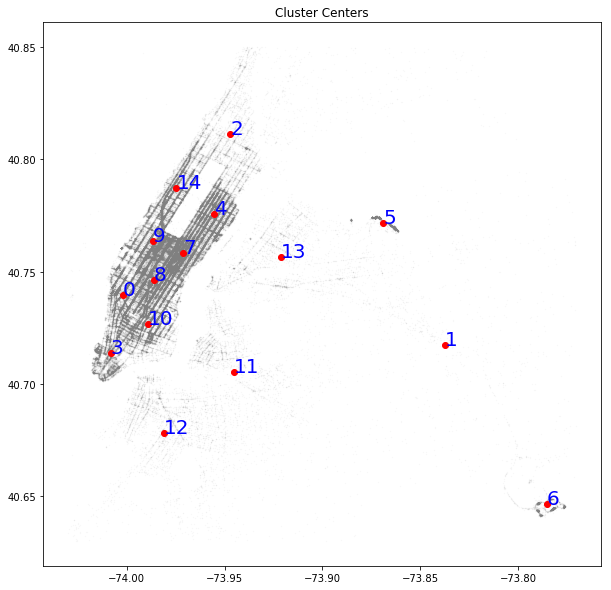

In [7]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [8]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )

In [9]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

In [10]:
loc_df = loc_df.sample(5000)

## Taxi rides from one cluster to another

And the following animation, every arrow represents rides from one cluster to another. The width of the arrow is proportional to the relative amount of trips in the relevant hour.

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



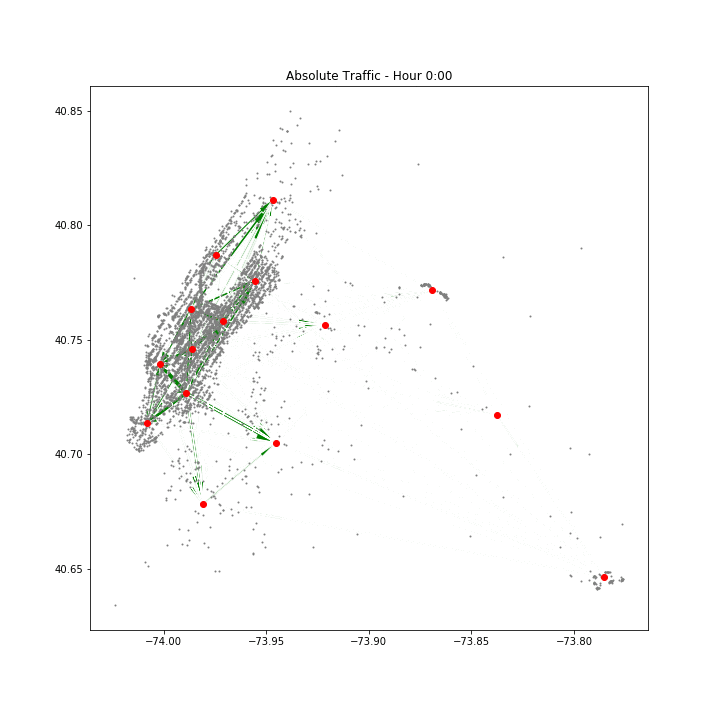

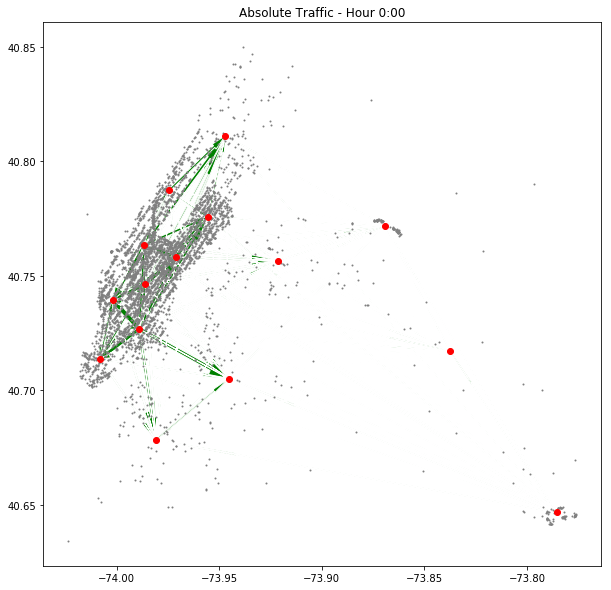

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



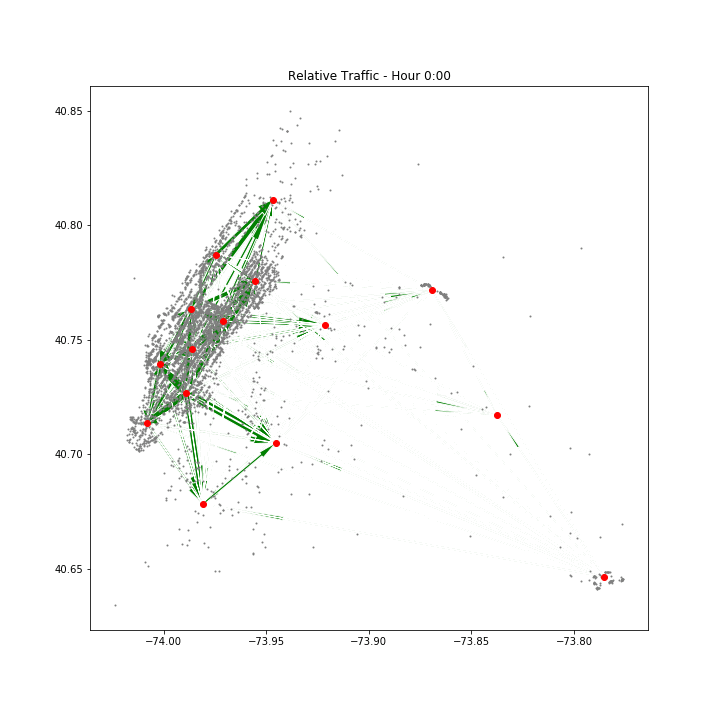

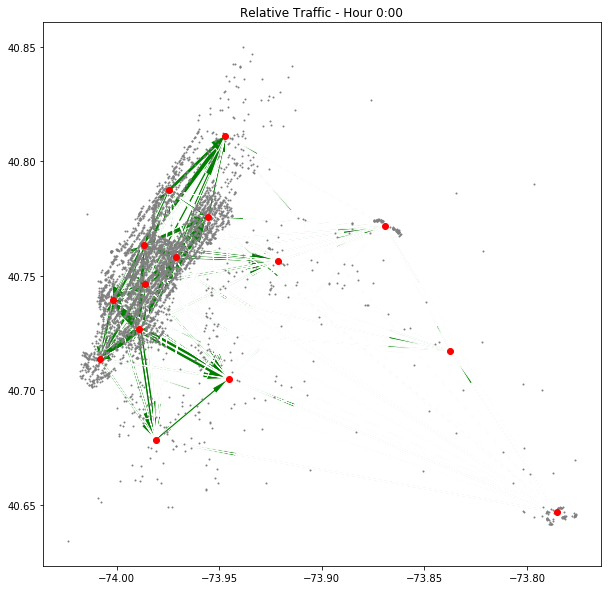

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

We can see that in the morning most of the traffic is in Manhattan island.

The share of taxis  travelling to Brooklyn area, mostly Williamsburg, becomes much larger in the late evening. Since there's no similar movement in the morning hours (in the opposite direction), this is unlikely to be the result of commuting.  Instead, and since the traffic is mostly seen after 22:00, these are probably people going out.

Since the arrows represent the relative traffic in the relevant hour, it is also possible that the increasing width of the arrows leading to Brooklyn may simply be a result of the reduction in the rides in Manhattan, due to the commercial character of big parts of it. But when looking at the absolute traffic, the arrows from Manhattan to Brooklyn are barely seen for the most part of the day.

In the very early morning, most of the traffic is to and from the two airports. As we can learn from the absolute graph, this is merely the result of decrease in traffic in the other parts of town. 

## Neighborhood Analysis

Le't manually assign the neighborhood name to each cluster


In [13]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [14]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [15]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Now let's plot a heatmap and look where do passengers go to and from (These are aggregate values of all rides):

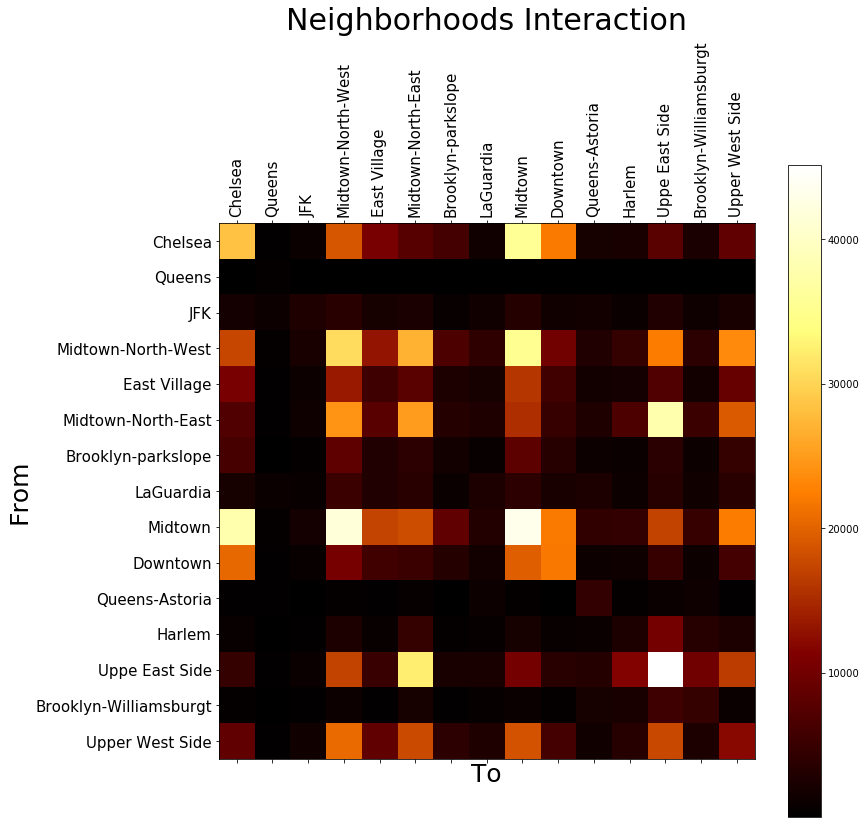

In [16]:
fig,ax = plt.subplots(figsize = (12,12))
cax = ax.matshow(rides_df.drop('name',axis = 1),interpolation='nearest',cmap=cm.afmhot)
cbar = fig.colorbar(cax)
ax.grid('off')
ax.set_xticks(range(len(rides_df)))
ax.set_xticklabels(rides_df.name, rotation =90,fontsize = 15)
ax.set_yticks(range(len(rides_df)))
ax.set_yticklabels(rides_df.name,fontsize = 15)
ax.set_xlabel('To', fontsize = 25)
ax.set_ylabel('From', fontsize = 25)
ax.set_title('Neighborhoods Interaction', y=1.35, fontsize = 30)

In [17]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis = 1)

We can see that center Manhattan neighborhoods are the most taxi-crowded, with Upper East side as the leader. We also see that the most common ride is within the cluster (which can not be seen in the animation). 

The heatmap is fairly symmetrical, meaning that there aren't clusters that significantly have more pickups than dropoffs or the other way around. Let's zoom on it:

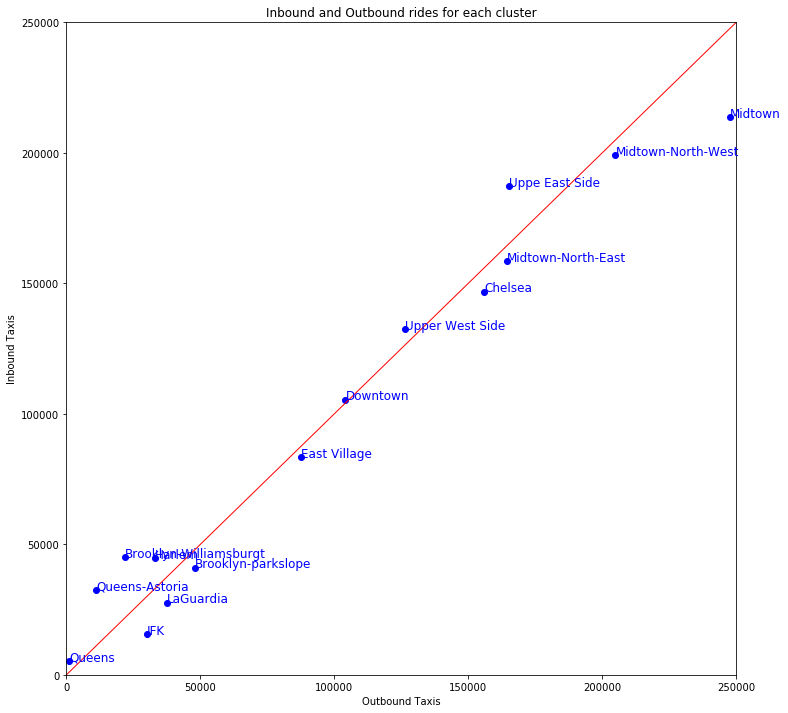

In [18]:
fig,ax = plt.subplots(figsize = (12,12))
for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    
    for col in rides_df.columns[:-1]:
        rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_hour = hor)]))

        
    for i in range(len(rides_df)):  
        ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
        ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

    ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
    ax.grid('off')
    ax.set_xlim([0,250000])
    ax.set_ylim([0,250000])
    ax.set_xlabel('Outbound Taxis')
    ax.set_ylabel('Inbound Taxis')
    ax.set_title('Inbound and Outbound rides for each cluster')



ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

SyntaxError: invalid syntax (<ipython-input-19-f4756563483b>, line 7)

We can see that the inbound-outbound ratio for each neighborhood is relatively balanced.

The two airports have more outbound rides than inbound, which makes sense - drivers would probably go to the airport even without passengers, to have the chance to take people into the city. The residential area - Quuens, Brooklyn and Harlem have more inbound ride, whereas the more commercial and touristic areas have more outbound. with Upper East and West, being both commercial and residential, almost on the curve.

It seems that people would go into Manhattan by alternative means of transportation, but are more likely to get out of it by a cab. 